# CornerNet 

By Group C (Polina Tsvilodub, Jan Kettler, Malte Heyen, Lukas Schießer, Shantanu Audichya)

CornerNet was first introduced by Law & Deng (2019) [1] and presents an alternative approach to object detection via detecting keypoints of the object bounding box. A convolutional network predicts two sets of heatmaps to  represent the locations of corners of different object categories, one set for the top-left corners and the other for the bottom-right corners. The network also predicts an embedding vector for each detected corner and is trained to minimize the distance between the embeddings of two corners from the same object. To produce tighter bounding boxes, the network also predicts offsets of the corners [1]. 

This notebook presents the implementation of CornerNet in TensorFlow as described [here](https://github.com/makalo/CornerNet), along with a toy example of model training on the MS COCO dataset. The original implementation can be found [here](https://github.com/princeton-vl/CornerNet).

The notebook is structured as follows: The original code from the repo referenced above is presented here as a single notebook and thoroughly commented, in order to facilitate self-study. Then, the model is trained on the [MS COCO dataset](https://cocodataset.org/#download). The original code is adjusted such as to be executable in a jupyter notebook. 

**! Warning !**

The notebook is only intended as an example. It only utilizes a small subset of the dataset---it actually trains on the 2017 validation set with 5000 images. Furthermore, the training duration is manually set to a 100 training steps only for purposes of making a quick example. These setting already require a lot of memory, so *the notebook should be run on Google Colab (using a GPU accelerator)!* 

## Example
As an example of the performance of the model, below you can see images with detected objects generated during training of the model.   

![Example of CornerNet output](example_images/0.jpg)
![Example of CornerNet output](example_images/10.jpg)
![Example of CornerNet output](example_images/20.jpg)
![Example of CornerNet output](example_images/30.jpg)
![Example of CornerNet output](example_images/40.jpg)
![Example of CornerNet output](example_images/50.jpg)
![Example of CornerNet output](example_images/60.jpg)
![Example of CornerNet output](example_images/70.jpg)
![Example of CornerNet output](example_images/80.jpg)
![Example of CornerNet output](example_images/90.jpg)

## Preparing the tools
First, download the COCO API and the dataset to the local directory.

In [ ]:
# create data directory
!mkdir data
# clone COCO API
!cd data; git clone https://github.com/cocodataset/cocoapi.git

mkdir: cannot create directory ‘data’: File exists
fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [ ]:
!cd data/cocoapi/PythonAPI/; make

python setup.py build_ext --inplace
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I../common -I/usr/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-ind

The MS COCO dataset has a particular format. It provides sets of annotated training, validation and testing images along with corresponding `.json` files containing the actual annotations. These annotations consist of class labels, bounding box coordinates and other meta-information. There are 80 classes in the dataset. The size of the splits depends on the version of the dataset. Here, the 2017 validation split containing 5000 images is used. Alternatively to the API, the 2014 dataset could be accessed via `tensorflow_datasets.load('Coco')` (**Warning**: this might be too large for the available Google Colab memory).  

In [ ]:
# create directory `annotations` in `cocoapi` and download chosen annotations from here: http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!cd data/cocoapi; mkdir annotations; 
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P data/cocoapi/annotations

mkdir: cannot create directory ‘annotations’: File exists
--2021-05-27 13:32:00--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.75.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.75.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘data/cocoapi/annotations/annotations_trainval2017.zip.3’

annotations_trainva 100%[===================>] 241.19M  89.7MB/s    in 2.7s    

2021-05-27 13:32:03 (89.7 MB/s) - ‘data/cocoapi/annotations/annotations_trainval2017.zip.3’ saved [252907541/252907541]



In [ ]:
# create the directory `images` in cocoapi 
# we only use the validation set for training the model because the memory availavle in colab isn't sufficient for managing the 2014 training data
# download zip files from https://cocodataset.org/#download (2017 Val images and 2017 test images) to `images`
!cd data/cocoapi; mkdir images;
!wget "http://images.cocodataset.org/zips/val2017.zip" -P data/cocoapi/images/; 
# download 2017 test data, if necessary; it is not used here  
#!wget "http://images.cocodataset.org/zips/test2017.zip" -P data/cocoapi/images/

mkdir: cannot create directory ‘images’: File exists
--2021-05-27 13:32:03--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.75.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.75.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘data/cocoapi/images/val2017.zip.3’

val2017.zip.3       100%[===================>] 777.80M  99.4MB/s    in 8.1s    

2021-05-27 13:32:11 (95.9 MB/s) - ‘data/cocoapi/images/val2017.zip.3’ saved [815585330/815585330]



In [ ]:
#unzip annotations
!unzip data/cocoapi/annotations/annotations_trainval2017.zip -d data/cocoapi/

Archive:  data/cocoapi/annotations/annotations_trainval2017.zip
replace data/cocoapi/annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# unzip validation data
!unzip data/cocoapi/images/val2017.zip -d data/cocoapi/images

Archive:  data/cocoapi/images/val2017.zip
replace data/cocoapi/images/val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# not used for this example
# unzip test data
#!unzip data/cocoapi/images/test2017.zip -d data/cocoapi/images

### Load the libraries

Here, the libraries used in the code are imported. Note that an older version of TensorFlow is used. 

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# libraries
import tensorflow as tf
import numpy as np
import math
# utility libraries
import sys
import cv2
from google.colab.patches import cv2_imshow
import random
import string
# libraries for handling the data
sys.path.append("./data/cocoapi/PythonAPI/")
import os
import json
import pickle
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import time

In [ ]:
# check
print(tf.__version__)

1.15.2


## Define helper modules

In the helper modules, the corner pooling function, the forward pass and the computation of the loss are implemented. The forward module also includes NMS. 


In [ ]:
# configuration of the training parameters
class Config:
    def __init__(self):
        self._configs = {}
        self._configs["dataset"] = None


        # Training Config
        self._configs["display"]           = 5
        self._configs["decay_step"]        = 12000 # learning rate decay
        self._configs["epoch_num"]         = 1 # 100 # nr of training epochs; 1 for example purposes
        self._configs["stepsize"]          = 450000
        self._configs["learning_rate"]     = 0.00025 # initial larning rate
        self._configs["decay_rate"]        = 0.95
        self._configs["max_iter"]          = 500000
        self._configs["val_iter"]          = 100
        self._configs["batch_size"]        = 5 # batch size
        self._configs["snapshot_name"]     = 'corner_net'
        self._configs["prefetch_size"]     = 100
        self._configs["weight_decay"]      = False
        self._configs["weight_decay_rate"] = 1e-5
        self._configs["weight_decay_type"] = "l2"
        self._configs["pretrain"]          = None
        self._configs["opt_algo"]          = "adam" # optimizer
        self._configs["chunk_sizes"]       = [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]



        # Directories
        # directory where the API and the data were cloned to
        self._configs["data_dir"]   = "./data" 
        # created during execution 
        self._configs["cache_dir"]  = "./cache"
        self._configs["config_dir"] = "./config"
        self._configs["result_dir"] = "./results"
        self._configs["debug_dir"]   = "./debug"

        # Split
        self._configs["train_split"] = "trainval" 
        self._configs["val_split"]   = "minival" 
        self._configs["test_split"]  = "testdev"

        # Rng
        self._configs["data_rng"] = np.random.RandomState(123)
        self._configs["nnet_rng"] = np.random.RandomState(317)

        #data_config
        self._configs["categories"]        =80 # number of categories
        self._configs["rand_scale_min"]    =0.6 
        self._configs["rand_scale_max"]    =1.4
        self._configs["rand_scale_step"]   =0.1
        self._configs["rand_scales"]       =[0.5,0.75,1,1.25,1.5]
        self._configs["rand_crop"]         =True # crop images during preprocessing
        self._configs["rand_color"]        =True # add random color perturbations
        self._configs["border"]            =128
        self._configs["gaussian_bump"]     =True
        self._configs["input_size"]        =[511,511] # input resolution
        self._configs["output_sizes"]      =[[128,128]] # training resolution
        self._configs["test_scales"]       =[0.5,0.75,1,1.25,1.5]
        self._configs["top_k"]             =100
        self._configs["ae_threshold"]      =0.5
        self._configs["nms_threshold"]     =0.5 # NMS threshold
        self._configs["merge_bbox"]        =True
        self._configs["weight_exp"]        =10
        self._configs["max_per_image"]     =100
        self._configs["gaussian_radius"]   =-1 # radius of 2D Gaussian heatmap for corner detection
        self._configs["gaussian_iou"]      =0.7 # IoU threshold

# set cofigurations
    @property
    def gaussian_iou(self):
        return self._configs["gaussian_iou"]
    @property
    def gaussian_radius(self):
        return self._configs["gaussian_radius"]
    @property
    def categories(self):
        return self._configs["categories"]
    @property
    def rand_scale_min(self):
        return self._configs["rand_scale_min"]
    @property
    def rand_scale_max(self):
        return self._configs["rand_scale_max"]
    @property
    def rand_scale_step(self):
        return self._configs["rand_scale_step"]
    @property
    def rand_scales(self):
        return self._configs["rand_scales"]
    @property
    def rand_crop(self):
        return self._configs["rand_crop"]
    @property
    def rand_color(self):
        return self._configs["rand_color"]
    @property
    def border(self):
        return self._configs["border"]
    @property
    def gaussian_bump(self):
        return self._configs["gaussian_bump"]
    @property
    def input_size(self):
        return self._configs["input_size"]
    @property
    def output_sizes(self):
        return self._configs["output_sizes"]
    @property
    def test_scales(self):
        return self._configs["test_scales"]
    @property
    def top_k(self):
        return self._configs["top_k"]
    @property
    def ae_threshold(self):
        return self._configs["ae_threshold"]
    @property
    def nms_threshold(self):
        return self._configs["nms_threshold"]
    @property
    def merge_bbox(self):
        return self._configs["merge_bbox"]
    @property
    def weight_exp(self):
        return self._configs["weight_exp"]
    @property
    def max_per_image(self):
        return self._configs["max_per_image"]
    @property
    def chunk_sizes(self):
        return self._configs["chunk_sizes"]

    @property
    def train_split(self):
        return self._configs["train_split"]

    @property
    def val_split(self):
        return self._configs["val_split"]

    @property
    def test_split(self):
        return self._configs["test_split"]

    @property
    def full(self):
        return self._configs

    @property
    def sampling_function(self):
        return self._configs["sampling_function"]

    @property
    def data_rng(self):
        return self._configs["data_rng"]

    @property
    def nnet_rng(self):
        return self._configs["nnet_rng"]

    @property
    def opt_algo(self):
        return self._configs["opt_algo"]

    @property
    def weight_decay_type(self):
        return self._configs["weight_decay_type"]

    @property
    def prefetch_size(self):
        return self._configs["prefetch_size"]

    @property
    def pretrain(self):
        return self._configs["pretrain"]

    @property
    def weight_decay_rate(self):
        return self._configs["weight_decay_rate"]

    @property
    def weight_decay(self):
        return self._configs["weight_decay"]

    @property
    def result_dir(self):
        result_dir = os.path.join(self._configs["result_dir"], self.snapshot_name)
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)
        return result_dir
    @property
    def debug_dir(self):
        debug_dir = os.path.join(self.cache_dir, "debug")
        if not os.path.exists(debug_dir):
            os.makedirs(debug_dir)
        return debug_dir

    @property
    def dataset(self):
        return self._configs["dataset"]

    @property
    def snapshot_name(self):
        return self._configs["snapshot_name"]

    @property
    def snapshot_dir(self):
        snapshot_dir = os.path.join(self.cache_dir, "nnet", self.snapshot_name)

        if not os.path.exists(snapshot_dir):
            os.makedirs(snapshot_dir)

        return snapshot_dir

    @property
    def snapshot_file(self):
        snapshot_file = os.path.join(self.snapshot_dir, self.snapshot_name + ".ckpt")
        return snapshot_file

    @property
    def config_dir(self):
        return self._configs["config_dir"]

    @property
    def batch_size(self):
        return self._configs["batch_size"]
    @property
    def epoch_num(self):
        return self._configs["epoch_num"]


    @property
    def max_iter(self):
        return self._configs["max_iter"]

    @property
    def learning_rate(self):
        return self._configs["learning_rate"]

    @property
    def decay_rate(self):
        return self._configs["decay_rate"]
    @property
    def decay_step(self):
        return self._configs["decay_step"]

    @property
    def stepsize(self):
        return self._configs["stepsize"]

    @property
    def snapshot(self):
        return self._configs["snapshot"]

    @property
    def display(self):
        return self._configs["display"]

    @property
    def val_iter(self):
        return self._configs["val_iter"]

    @property
    def data_dir(self):
        return self._configs["data_dir"]

    @property
    def cache_dir(self):
        if not os.path.exists(self._configs["cache_dir"]):
            os.makedirs(self._configs["cache_dir"])
        return self._configs["cache_dir"]

    def update_config(self, new):
        for key in new:
            if key in self._configs:
                self._configs[key] = new[key]

cfg = Config()

### Define submodules

Below, the corner pooling functions are defined. This is necessary to determine if a pixel is a top-left / bottom-right corner, since images often do not explicitly contain object corners. Therefore, we need to look horizontally towards the right for the top-most boundary of an object and vertically towards the bottom for the left-most boundary. To do this, explicit prior knowledge is encoded. Essentially, the feature maps produced by the convolutional feature extractor are max-pooled, and used to predict heatmaps, embeddings and offsets. The architecture of these prediction modules can be seen below.

![Corner prediction module](examples/prediction_module.png)

In [ ]:
# define helper modules

# corner pooling module
def TopPool(inputs):
    #forward
    def forward(inputs):
        out=tf.expand_dims(tf.reduce_max(inputs,1),1)
        i=tf.constant(1)
        batch,h,w,c=inputs.get_shape().as_list()
        def cond(i,out):
            return i < h
        def body(i,out):
            d=tf.expand_dims(tf.reduce_max(inputs[:,i:,:,:],1),1)
            out=tf.concat((out,d),1)
            i = i + 1
            return i,out
        _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,None,w,c])])
        return out
    #backward
    def backward(inputs,dy):
        zeros=tf.expand_dims(tf.zeros_like(inputs[:,-1,:,:]),1)
        ones=tf.expand_dims(tf.ones_like(inputs[:,-1,:,:]),1)
        mask=tf.expand_dims(tf.ones_like(inputs[:,-1,:,:]),1)
        batch,h,w,c=inputs.get_shape().as_list()
        i=tf.constant(h-1)

        def cond(i,mask):
            return i > 0
        def body(i,mask):
            max_value=tf.expand_dims(tf.reduce_max(inputs[:,i:,:,:],1),1)
            temp_mask=tf.where(tf.greater(tf.expand_dims(inputs[:,i-1,:,:],1),max_value),ones,zeros)
            mask=tf.concat((temp_mask,mask),1)
            i = i - 1
            return i,mask
        _,mask = tf.while_loop(cond, body, [i,mask],shape_invariants= [i.get_shape(), tf.TensorShape([batch,None,w,c])])
        return mask*dy

    @tf.custom_gradient
    def new_grad(x):
        def grad(dy):
            return backward(x,dy)
        return forward(x), grad
    return new_grad(inputs)
def LeftPool(inputs):
    #forward
    def forward(inputs):
        out=tf.expand_dims(tf.reduce_max(inputs,2),2)
        i=tf.constant(1)
        batch,h,w,c=inputs.get_shape().as_list()
        def cond(i,out):
            return i < w
        def body(i,out):
            d=tf.expand_dims(tf.reduce_max(inputs[:,:,i:,:],2),2)
            out=tf.concat((out,d),2)
            i = i + 1
            return i,out
        _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,h,None,c])])
        return out
    #backward
    def backward(inputs,dy):
        zeros=tf.expand_dims(tf.zeros_like(inputs[:,:,-1,:]),2)
        ones=tf.expand_dims(tf.ones_like(inputs[:,:,-1,:]),2)
        mask=tf.expand_dims(tf.ones_like(inputs[:,:,-1,:]),2)
        batch,h,w,c=inputs.get_shape().as_list()
        i=tf.constant(w-1)

        def cond(i,mask):
            return i > 0
        def body(i,mask):
            max_value=tf.expand_dims(tf.reduce_max(inputs[:,:,i:,:],2),2)
            temp_mask=tf.where(tf.greater(tf.expand_dims(inputs[:,:,i-1,:],2),max_value),ones,zeros)
            mask=tf.concat((temp_mask,mask),2)
            i = i - 1
            return i,mask
        _,mask = tf.while_loop(cond, body, [i,mask],shape_invariants= [i.get_shape(), tf.TensorShape([batch,h,None,c])])
        return mask*dy

    @tf.custom_gradient
    def new_grad(x):
        def grad(dy):
            return backward(x,dy)
        return forward(x), grad
    return new_grad(inputs)
def BottomPool(inputs):
    #forward
    def forward(inputs):
        out=tf.expand_dims(tf.reduce_max(inputs,1),1)
        batch,h,w,c=inputs.get_shape().as_list()
        i=tf.constant(h-1)

        def cond(i,out):
            return i > 0
        def body(i,out):
            d=tf.expand_dims(tf.reduce_max(inputs[:,:i,:,:],1),1)
            out=tf.concat((d,out),1)
            i = i - 1
            return i,out
        _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,None,w,c])])
        return out
    #backward
    def backward(inputs,dy):
        zeros=tf.expand_dims(tf.zeros_like(inputs[:,-1,:,:]),1)
        ones=tf.expand_dims(tf.ones_like(inputs[:,-1,:,:]),1)
        mask=tf.expand_dims(tf.ones_like(inputs[:,-1,:,:]),1)
        batch,h,w,c=inputs.get_shape().as_list()
        i=tf.constant(1)

        def cond(i,mask):
            return i < h
        def body(i,mask):
            max_value=tf.expand_dims(tf.reduce_max(inputs[:,:i,:,:],1),1)
            temp_mask=tf.where(tf.greater(tf.expand_dims(inputs[:,i,:,:],1),max_value),ones,zeros)
            mask=tf.concat((mask,temp_mask),1)
            i = i + 1
            return i,mask
        _,mask = tf.while_loop(cond, body, [i,mask],shape_invariants= [i.get_shape(), tf.TensorShape([batch,None,w,c])])
        return mask*dy

    @tf.custom_gradient
    def new_grad(x):
        def grad(dy):
            return backward(x,dy)
        return forward(x), grad
    return new_grad(inputs)
def RightPool(inputs):
    #forward
    def forward(inputs):
        out=tf.expand_dims(tf.reduce_max(inputs,2),2)
        batch,h,w,c=inputs.get_shape().as_list()
        i=tf.constant(w-1)

        def cond(i,out):
            return i > 0
        def body(i,out):
            d=tf.expand_dims(tf.reduce_max(inputs[:,:,:i,:],2),2)
            out=tf.concat((d,out),2)
            i = i - 1
            return i,out
        _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,h,None,c])])
        return out
    #backward
    def backward(inputs,dy):
        zeros=tf.expand_dims(tf.zeros_like(inputs[:,:,-1,:]),2)
        ones=tf.expand_dims(tf.ones_like(inputs[:,:,-1,:]),2)
        mask=tf.expand_dims(tf.ones_like(inputs[:,:,-1,:]),2)
        batch,h,w,c=inputs.get_shape().as_list()
        i=tf.constant(1)

        def cond(i,mask):
            return i < w
        def body(i,mask):
            max_value=tf.expand_dims(tf.reduce_max(inputs[:,:,:i,:],2),2)
            temp_mask=tf.where(tf.greater(tf.expand_dims(inputs[:,:,i,:],2),max_value),ones,zeros)
            mask=tf.concat((mask,temp_mask),2)
            i = i + 1
            return i,mask
        _,mask = tf.while_loop(cond, body, [i,mask],shape_invariants= [i.get_shape(), tf.TensorShape([batch,h,None,c])])
        return mask*dy

    @tf.custom_gradient
    def new_grad(x):
        def grad(dy):
            return backward(x,dy)
        return forward(x), grad
    return new_grad(inputs)

Below, post-processing of the detections via non-maximum suppression is defined. 

In [ ]:
# forward module

def nms(heat):
    hmax=tf.nn.max_pool(heat,ksize=[1,3,3,1],strides=[1,1,1,1],padding='SAME')
    mask=tf.cast(tf.equal(hmax,heat),tf.float32)
    return mask*heat
def top_k(heat,k=100):
    batch,h,w,c=heat.get_shape().as_list()
    heat=tf.reshape(heat,(batch,-1))
    k_value,k_index=tf.nn.top_k(heat,k)
    k_class=k_index//(h*w)
    k_position=k_index%(h*w)
    k_y=k_position//w#0 is also a cata
    k_x=k_position%w
    return k_value,k_position,k_class,k_y,k_x
def map_to_vector(feature_map,inds,transpose=True):
    #B*128*128*1
    #print(feature_map.get_shape().as_list())

    #assert tf.shape(inds)[1]==128
    def sub_map(value,select):
        value=tf.transpose(value,(1,0))
        sub_vector=tf.map_fn(fn=lambda x:tf.gather(x,select),elems=value,dtype=tf.float32)
        return tf.transpose(sub_vector,(1,0))
    if transpose:
        assert len(feature_map.get_shape().as_list())==4
        inter_vector=tf.reshape(feature_map,(feature_map.get_shape().as_list()[0],-1,feature_map.get_shape().as_list()[-1]))
    else:
        assert len(feature_map.get_shape().as_list())==3
        inter_vector=feature_map
    vector=tf.map_fn(fn=lambda p:sub_map(p[0],p[1]),elems=[inter_vector,inds],dtype=tf.float32)
    return vector
def expand_copy(feature_map,k,inter=False):
    feature_map=tf.expand_dims(feature_map,axis=-1)
    temp=feature_map
    for i in range(k-1):
        temp=tf.concat([temp,feature_map],-1)
    if inter:
        feature_map=tf.transpose(temp,(0,2,1))
    else:
        feature_map=temp
    assert feature_map.get_shape().as_list()[1]==feature_map.get_shape().as_list()[2]
    return feature_map

def rescale_dets(detections, ratios, borders, sizes):#may be problem
    xs, ys = detections[..., 0:4:2], detections[..., 1:4:2]
    xs=xs/ ratios[:, 1][:, None, None]#change the shape
    ys=ys/ ratios[:, 0][:, None, None]
    xs=xs- borders[:, 2][:, None, None]
    ys=ys- borders[:, 0][:, None, None]
    np.clip(xs, 0, sizes[:, 1][:, None, None], out=xs)
    np.clip(ys, 0, sizes[:, 0][:, None, None], out=ys)
    detections[..., 0:4:2], detections[..., 1:4:2]=xs, ys
    return detections
def soft_nms_merge(boxes,sigma=0.5, Nt=0.5, threshold=0.01, method=2, weight_exp=6):
    N = boxes.shape[0]
    pos = 0
    maxscore = 0
    maxpos = 0
    for i in range(N):
        maxscore = boxes[i, 4]
        maxpos = i

        tx1 = boxes[i,0]
        ty1 = boxes[i,1]
        tx2 = boxes[i,2]
        ty2 = boxes[i,3]
        ts = boxes[i,4]

        pos = i + 1
        # get max box
        while pos < N:
            if maxscore < boxes[pos, 4]:
                maxscore = boxes[pos, 4]
                maxpos = pos
            pos = pos + 1

        # add max box as a detection
        boxes[i,0] = boxes[maxpos,0]
        boxes[i,1] = boxes[maxpos,1]
        boxes[i,2] = boxes[maxpos,2]
        boxes[i,3] = boxes[maxpos,3]
        boxes[i,4] = boxes[maxpos,4]

        mx1 = boxes[i, 0] * boxes[i, 5]
        my1 = boxes[i, 1] * boxes[i, 5]
        mx2 = boxes[i, 2] * boxes[i, 6]
        my2 = boxes[i, 3] * boxes[i, 6]
        mts = boxes[i, 5]
        mbs = boxes[i, 6]

        # swap ith box with position of max box
        boxes[maxpos,0] = tx1
        boxes[maxpos,1] = ty1
        boxes[maxpos,2] = tx2
        boxes[maxpos,3] = ty2
        boxes[maxpos,4] = ts

        tx1 = boxes[i,0]
        ty1 = boxes[i,1]
        tx2 = boxes[i,2]
        ty2 = boxes[i,3]
        ts = boxes[i,4]

        pos = i + 1
        # NMS iterations, note that N changes if detection boxes fall below threshold
        while pos < N:
            x1 = boxes[pos, 0]
            y1 = boxes[pos, 1]
            x2 = boxes[pos, 2]
            y2 = boxes[pos, 3]
            s = boxes[pos, 4]

            area = (x2 - x1 + 1) * (y2 - y1 + 1)
            iw = (min(tx2, x2) - max(tx1, x1) + 1)
            if iw > 0:
                ih = (min(ty2, y2) - max(ty1, y1) + 1)
                if ih > 0:
                    ua = float((tx2 - tx1 + 1) * (ty2 - ty1 + 1) + area - iw * ih)
                    ov = iw * ih / ua #iou between max box and detection box

                    if method == 1: # linear
                        if ov > Nt:
                            weight = 1 - ov
                        else:
                            weight = 1
                    elif method == 2: # gaussian
                        weight = np.exp(-(ov * ov)/sigma)
                    else: # original NMS
                        if ov > Nt:
                            weight = 0
                        else:
                            weight = 1

                    mw  = (1 - weight) ** weight_exp
                    mx1 = mx1 + boxes[pos, 0] * boxes[pos, 5] * mw
                    my1 = my1 + boxes[pos, 1] * boxes[pos, 5] * mw
                    mx2 = mx2 + boxes[pos, 2] * boxes[pos, 6] * mw
                    my2 = my2 + boxes[pos, 3] * boxes[pos, 6] * mw
                    mts = mts + boxes[pos, 5] * mw
                    mbs = mbs + boxes[pos, 6] * mw

                    boxes[pos, 4] = weight*boxes[pos, 4]

                    # if box score falls below threshold, discard the box by swapping with last box
                    # update N
                    if boxes[pos, 4] < threshold:
                        boxes[pos,0] = boxes[N-1, 0]
                        boxes[pos,1] = boxes[N-1, 1]
                        boxes[pos,2] = boxes[N-1, 2]
                        boxes[pos,3] = boxes[N-1, 3]
                        boxes[pos,4] = boxes[N-1, 4]
                        N = N - 1
                        pos = pos - 1

            pos = pos + 1

        boxes[i, 0] = mx1 / mts
        boxes[i, 1] = my1 / mts
        boxes[i, 2] = mx2 / mbs
        boxes[i, 3] = my2 / mbs

    #keep = [i for i in range(N)]
    return boxes[0:N,:]

Below, the loss functions for the net are defined.

One aspect of the loss is the detection of the corners. In particular, the top left and the bottom right corners are detected. These are represented as two sets of heatmaps, one for each corner. Each set consists of 80 channels (corresponding to the number of categories) and has the dimensions 128x128 (=resolution). During training, the negative locations of the corner within a set radius of the ground truth positive location are penalized, represented as a 2D Gaussian. This is implemented as the *focal loss*. 
Furthermore, in order to get tighter bounding boxes, the offsets of the ground truth corner positions are also predicted. To learn these, the *smoothed L1 loss* is applied as the `offset_loss`. 
Finally, the `tag_loss` is used to learn the grouping of the corners of the same object. The goal is to minimize the distance between the embeddings of the corners of the same object, and maximize the distance for different objects. Specifically, the former component of the loss is called the *pull loss*, and the latter the *push loss*. 

In [ ]:
# loss module

# loss for learning the ground truth location of the corner
def focal_loss(preds,gt):
    print(gt.get_shape().as_list())
    zeros=tf.zeros_like(gt)
    ones=tf.ones_like(gt)
    num_pos=tf.reduce_sum(tf.where(tf.equal(gt,1),ones,zeros))
    loss=0
    #loss=tf.reduce_mean(tf.log(preds))
    for pre in preds:
        pos_weight=tf.where(tf.equal(gt,1),ones-pre,zeros)
        neg_weight=tf.where(tf.less(gt,1),pre,zeros)
        pos_loss=tf.reduce_sum(tf.log(pre) * tf.pow(pos_weight,2))
        neg_loss=tf.reduce_sum(tf.pow((1-gt),4)*tf.pow(neg_weight,2)*tf.log((1-pre)))
        loss=loss-(pos_loss+neg_loss)/(num_pos+tf.convert_to_tensor(1e-4))
    return loss

# loss for learning the grouping of the corners per object
def tag_loss(tag0, tag1, mask):
    #pull
    print(tag0.get_shape().as_list())
    tag0=tf.squeeze(tag0,axis=-1)
    tag1=tf.squeeze(tag1,axis=-1)
    zeros=tf.zeros_like(mask)
    ones=tf.ones_like(mask)
    num  = tf.reduce_sum(mask)


    tag_mean = (tag0 + tag1) / 2

    tag0 = tf.pow((tag0 - tag_mean) , 2) / (num + tf.convert_to_tensor(1e-4))
    #tag0_mask=tf.where(tf.equal(mask,1),ones,zeros)
    tag0 = tf.reduce_sum(tag0*mask)

    tag1 = tf.pow((tag1 - tag_mean), 2) / (num + tf.convert_to_tensor(1e-4))
    #tag1_mask=tf.where(tf.equal(mask,1),ones,zeros)
    tag1 = tf.reduce_sum(tag1*mask)
    pull = tag0 + tag1
    #push
    dist_mask=tf.reshape(mask,(tf.shape(mask)[0],1,tf.shape(mask)[1]))+tf.reshape(mask,(tf.shape(mask)[0],tf.shape(mask)[1],1))
    dist_zeros=tf.zeros_like(dist_mask)
    dist_ones=tf.ones_like(dist_mask)
    dist_mask=tf.where(tf.equal(dist_mask,2),dist_ones,dist_zeros)
    num2=num*(num-1)
    dist=tf.reshape(tag_mean,(tf.shape(tag_mean)[0],1,tf.shape(tag_mean)[1]))-tf.reshape(tag_mean,(tf.shape(tag_mean)[0],tf.shape(tag_mean)[1],1))
    #dist=-tf.pow(dist,2)
    dist=1-tf.abs(dist)
    dist=tf.nn.relu(dist)
    dist=dist-1 / (num + tf.convert_to_tensor(1e-4))
    dist=dist / (num2 + tf.convert_to_tensor(1e-4))
    dist=tf.multiply(dist_mask,dist)
    push=tf.reduce_sum(dist)
    return pull, push

# loss for learning the offset of the ground truth position of the corner
def offset_loss(offset, gt_offset, mask):
    num  = tf.reduce_sum(mask)
    mask = tf.stack((mask,mask),-1)
    offset_loss = smooth_l1_loss(offset, gt_offset)
    offset_loss = offset_loss / (num + tf.convert_to_tensor(1e-4))
    offset_loss=tf.reduce_sum(tf.multiply(offset_loss,mask))
    return offset_loss
def smooth_l1_loss(pred,targets,sigma=1):
    # diff = pred -targets
    # abs_diff = tf.abs(diff)
    # smoothL1_sign =tf.to_float(tf.less(abs_diff, 1))
    # loss = tf.pow(diff, 2) * 0.5 * smoothL1_sign + (abs_diff - 0.5) * (1. - smoothL1_sign)
    # return loss
    sigma2 = sigma * sigma

    diff = tf.subtract(pred, targets)

    smooth_l1_sign = tf.cast(tf.less(tf.abs(diff), 1.0 / sigma2), tf.float32)
    smooth_l1_option1 = tf.multiply(tf.multiply(diff, diff), 0.5 * sigma2)
    smooth_l1_option2 = tf.subtract(tf.abs(diff), 0.5 / sigma2)
    smooth_l1_result = tf.add(tf.multiply(smooth_l1_option1, smooth_l1_sign),tf.multiply(smooth_l1_option2, tf.abs(tf.subtract(smooth_l1_sign, 1.0))))
    return smooth_l1_result

Below, helper modules for importing and preparing the data are defined.

In [ ]:
# initialize data

class MSCOCO():
    def __init__(self,split):
        data_dir   = cfg.data_dir
        result_dir = cfg.result_dir
        cache_dir  = cfg.cache_dir

        self._split = split
       # for example purposes, due to memory limitations we only import one dataset
        self._dataset = {
            "trainval": "val2017",
            "minival": "val2017",
            "testdev": "val2017"
        }[self._split]

        self._coco_dir = os.path.join(data_dir, "cocoapi") # originally just "coco"

      # get annotations location
        self._label_dir  = os.path.join(self._coco_dir, "annotations")
        self._label_file = os.path.join(self._label_dir, "instances_{}.json")
        self._label_file = self._label_file.format(self._dataset)
        print(self._label_file)

        self._image_dir  = os.path.join(self._coco_dir, "images", self._dataset)
        self._image_file = os.path.join(self._image_dir, "{}")

        self._data = "coco"
        self._mean = np.array([0.40789654, 0.44719302, 0.47026115], dtype=np.float32)
        self._std  = np.array([0.28863828, 0.27408164, 0.27809835], dtype=np.float32)
        self._eig_val = np.array([0.2141788, 0.01817699, 0.00341571], dtype=np.float32)
        self._eig_vec = np.array([
            [-0.58752847, -0.69563484, 0.41340352],
            [-0.5832747, 0.00994535, -0.81221408],
            [-0.56089297, 0.71832671, 0.41158938]
        ], dtype=np.float32)

        self._cat_ids = [
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
            24, 25, 27, 28, 31, 32, 33, 34, 35, 36,
            37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
            48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
            58, 59, 60, 61, 62, 63, 64, 65, 67, 70,
            72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
            82, 84, 85, 86, 87, 88, 89, 90
        ]
        self._classes = {
            ind + 1: cat_id for ind, cat_id in enumerate(self._cat_ids)
        }
        self._coco_to_class_map = {
            value: key for key, value in self._classes.items()
        }
# cache loaded dataset
        self._cache_file = os.path.join(cache_dir, "coco_{}.pkl".format(self._dataset))
        self._load_data()
        self._db_inds = np.arange(len(self._image_ids))

        self._load_coco_data()


    def _load_data(self):
        print("loading from cache file: {}".format(self._cache_file))
        if not os.path.exists(self._cache_file):
            print("No cache file found...")
            self._extract_data()
            with open(self._cache_file, "wb") as f:
                pickle.dump([self._detections, self._image_ids], f)#self._image_ids is img's name.self._detections is {name:box and cat([N,5])}
        else:
            with open(self._cache_file, "rb") as f:
                self._detections, self._image_ids = pickle.load(f)
        
# load annotations
    def _load_coco_data(self):
        self._coco = COCO(self._label_file)
        with open(self._label_file, "r") as f:
            data = json.load(f)

        coco_ids = self._coco.getImgIds()
        eval_ids = {
            self._coco.loadImgs(coco_id)[0]["file_name"]: coco_id
            for coco_id in coco_ids
        }
# get categories
        self._coco_categories = data["categories"]
        self._coco_eval_ids   = eval_ids

    def class_name(self, cid):
        cat_id = self._classes[cid]
        cat    = self._coco.loadCats([cat_id])[0]
        return cat["name"]

    def _extract_data(self):
        self._coco    = COCO(self._label_file)
        self._cat_ids = self._coco.getCatIds()

        coco_image_ids = self._coco.getImgIds()

        self._image_ids = [
            self._coco.loadImgs(img_id)[0]["file_name"]
            for img_id in coco_image_ids
        ]
        self._detections = {}
        for ind, (coco_image_id, image_id) in enumerate(tqdm(zip(coco_image_ids, self._image_ids))):
            image      = self._coco.loadImgs(coco_image_id)[0]
            bboxes     = []
            categories = []
# map categories and bounding boxes to images
            for cat_id in self._cat_ids:
                annotation_ids = self._coco.getAnnIds(imgIds=image["id"], catIds=cat_id)
                annotations    = self._coco.loadAnns(annotation_ids)
                category       = self._coco_to_class_map[cat_id]
                for annotation in annotations:
                    bbox = np.array(annotation["bbox"])
                    bbox[[2, 3]] += bbox[[0, 1]]
                    bboxes.append(bbox)

                    categories.append(category)

            bboxes     = np.array(bboxes, dtype=float)
            categories = np.array(categories, dtype=float)
            if bboxes.size == 0 or categories.size == 0:
                self._detections[image_id] = np.zeros((0, 5), dtype=np.float32)
            else:
                self._detections[image_id] = np.hstack((bboxes, categories[:, None]))#each image's all boxes and box's cat [N,4]
  # helpers              
    def get_all_img(self):
        return self._image_ids
    def read_img(self,img_name):
        print(img_name)
        img_path =self._image_file.format(bytes.decode(img_name)) # .encode() img_name
        img=cv2.imread(img_path)
        return img.astype(np.float32)
    def detections(self, img_name):
        detections = self._detections[bytes.decode(img_name)]

        return detections.astype(float).copy()

    def _to_float(self, x):
        return float("{:.2f}".format(x))

    def convert_to_coco(self, all_bboxes):
        detections = []
        for image_id in all_bboxes:
            coco_id = self._coco_eval_ids[image_id]
            for cls_ind in all_bboxes[image_id]:
                category_id = self._classes[cls_ind]
                for bbox in all_bboxes[image_id][cls_ind]:
                    bbox[2] -= bbox[0]
                    bbox[3] -= bbox[1]

                    score = bbox[4]
                    bbox  = list(map(self._to_float, bbox[0:4]))

                    detection = {
                        "image_id": coco_id,
                        "category_id": category_id,
                        "bbox": bbox,
                        "score": float("{:.2f}".format(score))
                    }

                    detections.append(detection)
        return detections
# evaluate predicted bboxes on testdata 
    def evaluate(self, result_json, cls_ids, image_ids, gt_json=None):
        if self._split == "testdev":
            return None

        coco = self._coco if gt_json is None else COCO(gt_json)

        eval_ids = [self._coco_eval_ids[image_id] for image_id in image_ids]
        cat_ids  = [self._classes[cls_id] for cls_id in cls_ids]

        coco_dets = coco.loadRes(result_json)
        coco_eval = COCOeval(coco, coco_dets, "bbox")
        coco_eval.params.imgIds = eval_ids
        coco_eval.params.catIds = cat_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        return coco_eval.stats[0], coco_eval.stats[12:]

Here, possible transformations of the images for improving performance are defined. The 2D Gaussian used in the corner localization is also defined here. 

In [ ]:
# transformation
def full_image_crop(image, detections):
    detections    = detections.copy()
    height, width = image.shape[0:2]

    max_hw = max(height, width)
    center = [height // 2, width // 2]
    size   = [max_hw, max_hw]

    image, border, offset = crop_image(image, center, size)
    detections[:, 0:4:2] += border[2]
    detections[:, 1:4:2] += border[0]
    return image, detections

def resize_image(image, detections, size):
    detections    = detections.copy()
    height, width = image.shape[0:2]
    new_height, new_width = size

    image = cv2.resize(image, (new_width, new_height))

    height_ratio = new_height / height
    width_ratio  = new_width  / width
    detections[:, 0:4:2] *= width_ratio
    detections[:, 1:4:2] *= height_ratio
    return image, detections

def clip_detections(image, detections):
    detections    = detections.copy()
    height, width = image.shape[0:2]

    detections[:, 0:4:2] = np.clip(detections[:, 0:4:2], 0, width - 1)
    detections[:, 1:4:2] = np.clip(detections[:, 1:4:2], 0, height - 1)
    keep_inds  = ((detections[:, 2] - detections[:, 0]) > 0) & \
                 ((detections[:, 3] - detections[:, 1]) > 0)
    detections = detections[keep_inds]
    return detections

# define heatmap of negative corner location penalties  
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = center

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)

def gaussian_radius(det_size, min_overlap):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)

def _get_border(border, size):
    i = 1
    while size - border // i <= border // i:
        i *= 2
    return border // i

def random_crop(image, detections, random_scales, view_size, border=64):
    view_height, view_width   = view_size
    image_height, image_width = image.shape[0:2]

    scale  = np.random.choice(random_scales)
    height = int(view_height * scale)
    width  = int(view_width  * scale)

    cropped_image = np.zeros((height, width, 3), dtype=image.dtype)

    w_border = _get_border(border, image_width)
    h_border = _get_border(border, image_height)

    ctx = np.random.randint(low=w_border, high=image_width - w_border)
    cty = np.random.randint(low=h_border, high=image_height - h_border)

    x0, x1 = max(ctx - width // 2, 0),  min(ctx + width // 2, image_width)
    y0, y1 = max(cty - height // 2, 0), min(cty + height // 2, image_height)

    left_w, right_w = ctx - x0, x1 - ctx
    top_h, bottom_h = cty - y0, y1 - cty

    # crop image
    cropped_ctx, cropped_cty = width // 2, height // 2
    x_slice = slice(cropped_ctx - left_w, cropped_ctx + right_w)
    y_slice = slice(cropped_cty - top_h, cropped_cty + bottom_h)
    cropped_image[y_slice, x_slice, :] = image[y0:y1, x0:x1, :]

    # crop detections
    cropped_detections = detections.copy()
    cropped_detections[:, 0:4:2] -= x0
    cropped_detections[:, 1:4:2] -= y0
    cropped_detections[:, 0:4:2] += cropped_ctx - left_w
    cropped_detections[:, 1:4:2] += cropped_cty - top_h

    return cropped_image, cropped_detections

# add perturbations to images to improve performance    
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_(image, mean, std):
    image -= mean
    image /= std

def lighting_(data_rng, image, alphastd, eigval, eigvec):
    alpha = data_rng.normal(scale=alphastd, size=(3, ))
    image += np.dot(eigvec, eigval * alpha)

def blend_(alpha, image1, image2):
    image1 *= alpha
    image2 *= (1 - alpha)
    image1 += image2

def saturation_(data_rng, image, gs, gs_mean, var):
    alpha = 1. + data_rng.uniform(low=-var, high=var)
    blend_(alpha, image, gs[:, :, None])

def brightness_(data_rng, image, gs, gs_mean, var):
    alpha = 1. + data_rng.uniform(low=-var, high=var)
    image *= alpha

def contrast_(data_rng, image, gs, gs_mean, var):
    alpha = 1. + data_rng.uniform(low=-var, high=var)
    blend_(alpha, image, gs_mean)

def color_jittering_(data_rng, image):
    functions = [brightness_, contrast_, saturation_]
    random.shuffle(functions)

    gs = grayscale(image)
    gs_mean = gs.mean()
    for f in functions:
        f(data_rng, image, gs, gs_mean, 0.4)
def crop_image(image, center, size):
    cty, ctx            = center
    height, width       = size
    im_height, im_width = image.shape[0:2]
    cropped_image       = np.zeros((height, width, 3), dtype=image.dtype)

    x0, x1 = max(0, ctx - width // 2), min(ctx + width // 2, im_width)
    y0, y1 = max(0, cty - height // 2), min(cty + height // 2, im_height)

    left, right = ctx - x0, x1 - ctx
    top, bottom = cty - y0, y1 - cty

    cropped_cty, cropped_ctx = height // 2, width // 2
    y_slice = slice(cropped_cty - top, cropped_cty + bottom)
    x_slice = slice(cropped_ctx - left, cropped_ctx + right)
    cropped_image[y_slice, x_slice, :] = image[y0:y1, x0:x1, :]

    border = np.array([
       cropped_cty - top,
       cropped_cty + bottom,
       cropped_ctx - left,
       cropped_ctx + right
    ], dtype=np.float32)

    offset = np.array([
        cty - height // 2,
        ctx - width  // 2
    ])

    return cropped_image, border, offset

Below, the data is loaded and batched. 

In [ ]:
# get data
class Image_data():
    def __init__(self,split):
        self.coco=MSCOCO(split)
        self.data_rng   = cfg.data_rng
        self.num_image  = len(self.coco.get_all_img())
        self.categories   = cfg.categories
        self.input_size   = cfg.input_size
        self.output_size  = cfg.output_sizes[0]

        self.border        = cfg.border
        #self.lighting      = cfg.lighting
        self.rand_crop     = cfg.rand_crop
        print(self.rand_crop)
        self.rand_color    = cfg.rand_color
        self.rand_scales   = cfg.rand_scales
        self.gaussian_bump = cfg.gaussian_bump
        self.gaussian_iou  = cfg.gaussian_iou
        self.gaussian_rad  = cfg.gaussian_radius
    def read_from_disk(self,queue):
        # allocating memory
        max_tag_len = 128
        image       = np.zeros((self.input_size[0], self.input_size[1],3), dtype=np.float32)
        heatmaps_tl = np.zeros((self.output_size[0], self.output_size[1],self.categories), dtype=np.float32)
        heatmaps_br = np.zeros((self.output_size[0], self.output_size[1],self.categories), dtype=np.float32)
        offsets_tl    = np.zeros((max_tag_len, 2), dtype=np.float32)
        offsets_br    = np.zeros((max_tag_len, 2), dtype=np.float32)
        tags_tl     = np.zeros((max_tag_len), dtype=np.int64)
        tags_br     = np.zeros((max_tag_len), dtype=np.int64)
        tags_mask   = np.zeros((max_tag_len), dtype=np.float32)
        boxes       = np.zeros((max_tag_len,4), dtype=np.int64)
        ratio       = np.ones((max_tag_len,2), dtype=np.float32)
        tag_lens    = 0

        # reading image
        image=self.coco.read_img(queue[0])

        # reading detections
        detections = self.coco.detections(queue[0])

        # cropping an image randomly
        if self.rand_crop:
            image, detections = random_crop(image, detections, self.rand_scales, self.input_size, border=self.border)
        else:
            image, detections = full_image_crop(image, detections)

        image, detections = resize_image(image, detections, self.input_size)
        detections = clip_detections(image, detections)

        width_ratio  = self.output_size[1] / self.input_size[1]
        height_ratio = self.output_size[0] / self.input_size[0]

        # flipping an image randomly
        if np.random.uniform() > 0.5:
            image[:] = image[:, ::-1, :]
            width    = image.shape[1]
            detections[:, [0, 2]] = width - detections[:, [2, 0]] - 1


        image = image.astype(np.float32) / 255.


        for ind, detection in enumerate(detections):
            category = int(detection[-1]) - 1

            xtl_ori, ytl_ori = detection[0], detection[1]
            xbr_ori, ybr_ori = detection[2], detection[3]

            fxtl = (xtl_ori * width_ratio)
            fytl = (ytl_ori * height_ratio)
            fxbr = (xbr_ori * width_ratio)
            fybr = (ybr_ori * height_ratio)


            xtl = int(fxtl)
            ytl = int(fytl)
            xbr = int(fxbr)
            ybr = int(fybr)

        # add heatmaps
            if self.gaussian_bump:
                width  = detection[2] - detection[0]
                height = detection[3] - detection[1]

                width  = math.ceil(width * width_ratio)
                height = math.ceil(height * height_ratio)

                if self.gaussian_rad == -1:
                    radius = gaussian_radius((height, width), self.gaussian_iou)
                    radius = max(0, int(radius))
                else:
                    radius = self.gaussian_rad

                draw_gaussian(heatmaps_tl[:,:,category], [xtl, ytl], radius)
                draw_gaussian(heatmaps_br[:,:,category], [xbr, ybr], radius)
            else:
                heatmaps_tl[ytl, xtl, category] = 1
                heatmaps_br[ybr, xbr, category] = 1

            tag_ind = tag_lens
            offsets_tl[tag_ind, :] = [fxtl - xtl, fytl - ytl]
            offsets_br[tag_ind, :] = [fxbr - xbr, fybr - ybr]
            tags_tl[tag_ind] = ytl * self.output_size[1] + xtl
            tags_br[tag_ind] = ybr * self.output_size[1] + xbr
            boxes[tag_ind] = [xtl_ori,ytl_ori,xbr_ori,ybr_ori]
            ratio[tag_ind] = [width_ratio,height_ratio]
            tag_lens += 1
        tags_mask[:tag_lens] = 1
        return image, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio
# get training data example by example using eager execution 
    def get_single_data(self,queue):
        images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio=tf.py_func(self.read_from_disk,[queue], [tf.float32,tf.int64,tf.int64,tf.float32,tf.float32,tf.float32,tf.float32,tf.float32,tf.int64,tf.float32])
        return images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio
# slice all the training data   
    def inupt_producer(self):
        quene_train=tf.train.slice_input_producer([self.coco.get_all_img()],shuffle=True)
        self.images, self.tags_tl, self.tags_br,self.heatmaps_tl, self.heatmaps_br, self.tags_mask, self.offsets_tl, self.offsets_br,self.boxes,self.ratio=self.get_single_data(quene_train)
# batch training data
    def get_batch_data(self,batch_size):
        images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio=tf.train.shuffle_batch([self.images,
            self.tags_tl, self.tags_br,self.heatmaps_tl, self.heatmaps_br, self.tags_mask, self.offsets_tl, self.offsets_br,self.boxes,self.ratio],
            batch_size=batch_size,shapes=[(self.input_size[0], self.input_size[1],3),(128),(128),
            (self.output_size[0], self.output_size[1],self.categories),(self.output_size[0], self.output_size[1],self.categories),
            (128),(128,2),(128,2),(128,4),(128,2)],capacity=100,min_after_dequeue=batch_size,num_threads=16)
        return images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio
# execute data preparation
if __name__=='__main__':
    data=Image_data('trainval')
    data.inupt_producer()
    images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio=data.get_batch_data(2)
    sess=tf.InteractiveSession()
    coord = tf.train.Coordinator()
    threads=tf.train.start_queue_runners(sess=sess,coord=coord)
    for i in range(12):
        images_, tags_tl_, tags_br_,heatmaps_tl_, heatmaps_br_, tags_mask_, offsets_tl_, offsets_br_,boxes_= sess.run([images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes])
        for j in range(2):
            #print(images_.shape,tags_tl_.shape,heatmaps_tl_.shape,tags_mask_.shape,offsets_tl_.shape)
            img=(images_[j]*255).astype(np.uint8)
            heat_1=np.max(heatmaps_tl_[j],axis=-1)
            heat_cat=np.zeros_like(heat_1)
            heat_cat[np.where(heat_1==1)]=1
            heat_arg=np.argmax(heat_cat,-1)
            print(heat_arg)
            heat_1=heat_1*255
            heat_1=heat_1.astype(np.uint8)
            heat_1=np.stack([heat_1,heat_1,heat_1],-1)

            heat_2=np.max(heatmaps_br_[j],axis=-1)*255
            heat_2=heat_2.astype(np.uint8)
            heat_2=np.stack([heat_2,heat_2,heat_2],-1)

            heat=heat_1+heat_2
            heat=cv2.resize(heat,(511,511))
            norm=cv2.addWeighted(img,0.5,heat,0.5,0)
            box=boxes_[j]
            for b in box:
                cv2.rectangle(norm ,(b[0],b[1]),(b[2],b[3]),(225,225,0),1)
            # shows image, but might crash jupyter session    
            #cv2.imshow('img',norm)
            cv2.waitKey(0)
    coord.request_stop()
    coord.join(threads)
    sess.close()

./data/cocoapi/annotations/instances_val2017.json
loading from cache file: ./cache/coco_val2017.pkl
loading annotations into memory...
Done (t=1.11s)
creating index...
index created!
True
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by

### Define the net 

Below, the entire model is put together. For overview, the entire architecture is depicted below. In particular, the feature extractor is defined as a so-called hourglass network. The feature maps are then fed into the prediction modules. 

![CornerNet architecture](examples/cornernet_architecture.png)

In [ ]:
# model
class Model():
  # define concolutional layers of the predication module
    def conv_bn_re(self,inputs,input_dim,out_dim,strides=(1,1),use_relu=True,use_bn=True,k=3,is_training=True,scope='conv_bn_re'):
        with tf.variable_scope(scope):
            x=tf.layers.conv2d(inputs,out_dim,k,strides=strides,padding='same')
            if use_bn:
                x=tf.contrib.layers.batch_norm(x,is_training=is_training)
            if use_relu:
                x=tf.nn.relu(x)
            return x
    # define residual connections        
    def residual(self,inputs,input_dim,out_dim,k=3,strides=(1,1),is_training=True,scope='residual'):
        with tf.variable_scope(scope):
            #low layer 3*3>3*3
            x=self.conv_bn_re(inputs,input_dim,out_dim,strides=strides,is_training=is_training,scope='up_1')
            x=self.conv_bn_re(x,out_dim,out_dim,use_relu=False,is_training=is_training,scope='up_2')
            #skip,up layer 1*1
            skip=self.conv_bn_re(inputs,input_dim,out_dim,strides=strides,use_relu=False,k=1,is_training=is_training,scope='low')
            #skip+x
            res=tf.nn.relu(tf.add(skip,x))
            return res
    # define residual blocks for the hourglass network         
    def res_block(self,inputs,input_dim,out_dim,n,k=3,is_training=True,scope='res_block'):
        with tf.variable_scope(scope):
            x=self.residual(inputs,input_dim,out_dim,k=k,is_training=is_training,scope='residual_0')
            for i in range(1,n):
                x=self.residual(x,out_dim,out_dim,k=k,is_training=is_training,scope='residual_%d'%i)
            return x
    # define hourglass network        
    def hourglass(self,inputs,n_deep,n_res,n_dims,is_training=True,scope='hourglass_5'):
        with tf.variable_scope(scope):
            curr_res=n_res[0]
            next_res=n_res[1]
            curr_dim=n_dims[0]
            next_dim=n_dims[1]

            up_1=self.res_block(inputs,curr_dim,curr_dim,curr_res,is_training=is_training,scope='up_1')

            half=tf.nn.max_pool(inputs,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
            low_1=self.res_block(half,curr_dim,next_dim,curr_res,is_training=is_training,scope='low_1')
            if n_deep>1:
                low_2=self.hourglass(low_1,n_deep-1,n_res[1:],n_dims[1:],is_training=is_training,scope='hourglass_%d'%(n_deep-1))
            else:
                low_2=self.res_block(low_1,next_dim,next_dim,next_res,is_training=is_training,scope='low_2')
            low_3=self.res_block(low_2,next_dim,curr_dim,curr_res,is_training=is_training,scope='low_3')

            up_2=tf.image.resize_nearest_neighbor(low_3,tf.shape(low_3)[1:3]*2,name='up_2')
            merge=tf.add(up_1,up_2)
            return merge
    def start_conv(self,img,is_training=True,scope='start'):
        with tf.variable_scope(scope):
            x=tf.contrib.layers.conv2d(img,128,7,2)
            x=tf.contrib.layers.batch_norm(x,is_training=is_training)
            x=self.residual(x,128,256,strides=(2,2),scope='residual_start')
            return x
    # define corner pooling module in the prediction block        
    def corner_pooling(self,inputs,input_dim,out_dim,k=3,is_training=True,scope='corner_pooling'):
        with tf.variable_scope(scope):
            with tf.variable_scope('top_left'):
                top=self.conv_bn_re(inputs,input_dim,128,is_training=is_training,scope='top')
                top_pool=TopPool(top)

                left=self.conv_bn_re(inputs,input_dim,128,is_training=is_training,scope='left')
                left_pool=LeftPool(left)

                top_left=tf.add(top_pool,left_pool)
                top_left=self.conv_bn_re(top_left,128,out_dim,use_relu=False,is_training=is_training,scope='top_left')

                skip_tl=self.conv_bn_re(inputs,input_dim,out_dim,use_relu=False,k=1,is_training=is_training,scope='skip')

                merge_tl=tf.nn.relu(tf.add(skip_tl,top_left))
                merge_tl=self.conv_bn_re(merge_tl,out_dim,out_dim,is_training=is_training,scope='merge_tl')
            with tf.variable_scope('bottom_right'):
                bottom=self.conv_bn_re(inputs,input_dim,128,is_training=is_training,scope='bottom')
                bottom_pool=BottomPool(bottom)

                right=self.conv_bn_re(inputs,input_dim,128,is_training=is_training,scope='right')
                right_pool=RightPool(right)

                bottom_right=tf.add(bottom_pool,right_pool)
                bottom_right=self.conv_bn_re(bottom_right,128,out_dim,use_relu=False,is_training=is_training,scope='bottom_right')

                skip_br=self.conv_bn_re(inputs,input_dim,out_dim,use_relu=False,k=1,is_training=is_training,scope='skip')

                merge_br=tf.nn.relu(tf.add(skip_br,bottom_right))
                merge_br=self.conv_bn_re(merge_br,out_dim,out_dim,is_training=is_training,scope='merge_br')
            return merge_tl,merge_br
    # define forward passes
    def heat(self,inputs,input_dim,out_dim,scope='heat'):
        #out_dim=80
        with tf.variable_scope(scope):
            x=self.conv_bn_re(inputs,input_dim,input_dim,use_bn=False)
            x=tf.layers.conv2d(x,out_dim,1)
            return x
    def tag(self,inputs,input_dim,out_dim,scope='tag'):
        #out_dim=1
        with tf.variable_scope(scope):
            x=self.conv_bn_re(inputs,input_dim,input_dim,use_bn=False)
            x=tf.layers.conv2d(x,out_dim,1)
            return x
    def offset(self,inputs,input_dim,out_dim,scope='offset'):
        #out_dim=2
        with tf.variable_scope(scope):
            x=self.conv_bn_re(inputs,input_dim,input_dim,use_bn=False)
            x=tf.layers.conv2d(x,out_dim,1)
            return x
    def hinge(self,inputs,input_dim,out_dim,is_training=True,scope='hinge'):
        with tf.variable_scope(scope):
            x=self.conv_bn_re(inputs,input_dim,out_dim,is_training=is_training)
            return x
    def inter(self,input_1,input_2,out_dim,is_training=True,scope='inter'):
        with tf.variable_scope(scope):
            x_1=self.conv_bn_re(input_1,tf.shape(input_1)[3],out_dim,use_relu=False,k=1,is_training=is_training,scope='branch_start')
            x_2=self.conv_bn_re(input_2,tf.shape(input_2)[3],out_dim,use_relu=False,k=1,is_training=is_training,scope='branch_hourglass1')
            x=tf.nn.relu(tf.add(x_1,x_2))
            x=self.residual(x,out_dim,out_dim,is_training=is_training)
            return x

In [ ]:
# put together all the modules of the network

class NetWork():
    def __init__(self,pull_weight=0.1, push_weight=0.1, offset_weight=1):
      # configurations of the net
        self.n_deep  = 5
        self.n_dims  = [256, 256, 384, 384, 384, 512]
        self.n_res   = [2, 2, 2, 2, 2, 4]
        self.out_dim = 80
        self.model=Model()
        self.pull_weight = pull_weight
        self.push_weight = push_weight
        self.offset_weight = offset_weight
        self.focal_loss  = focal_loss
        self.tag_loss     = tag_loss
        self.offset_loss   = offset_loss
    def corner_net(self,img,gt_tag_tl=None,gt_tag_br=None,is_training=True,scope='CornerNet'):
        with tf.variable_scope(scope):

            outs=[]
            test_outs=[]
            start_layer=self.model.start_conv(img,is_training=is_training)#[b,128,128,256]

            with tf.variable_scope('inter_supervise'):

                hourglass_1=self.model.hourglass(start_layer,self.n_deep,self.n_res,self.n_dims,is_training=is_training)#[b,128,128,256]
                hinge_is=self.model.hinge(hourglass_1,256,256,is_training=is_training)
                top_left_is,bottom_right_is=self.model.corner_pooling(hinge_is,256,256,is_training=is_training)
                #top_left
                heat_tl_is=self.model.heat(top_left_is,256,self.out_dim,scope='heat_tl')
                tag_tl_is=self.model.tag(top_left_is,256,1,scope='tag_tl')
                if not gt_tag_tl is None:
                    tag_tl_is=map_to_vector(tag_tl_is,gt_tag_tl)
                offset_tl_is=self.model.offset(top_left_is,256,2,scope='offset_tl')
                if not gt_tag_tl is None:
                    offset_tl_is=map_to_vector(offset_tl_is,gt_tag_tl)
                #bottom_right
                heat_br_is=self.model.heat(bottom_right_is,256,self.out_dim,scope='heat_br')
                tag_br_is=self.model.tag(bottom_right_is,256,1,scope='tag_br')
                if not gt_tag_br is None:
                    tag_br_is=map_to_vector(tag_br_is,gt_tag_br)
                offset_br_is=self.model.offset(bottom_right_is,256,2,scope='offset_br')
                if not gt_tag_br is None:
                    offset_br_is=map_to_vector(offset_br_is,gt_tag_br)


            with tf.variable_scope('master_branch'):
                inter=self.model.inter(start_layer,hinge_is,256,is_training=is_training)
                hourglass_2=self.model.hourglass(inter,self.n_deep,self.n_res,self.n_dims,is_training=is_training)#[b,128,128,256]
                hinge=self.model.hinge(hourglass_2,256,256,is_training=is_training)
                top_left,bottom_right=self.model.corner_pooling(hinge,256,256,is_training=is_training)
                #top_left
                heat_tl=self.model.heat(top_left,256,self.out_dim,scope='heat_tl')
                tag_tl_test=self.model.tag(top_left,256,1,scope='tag_tl')
                if not gt_tag_tl is None:
                    tag_tl=map_to_vector(tag_tl_test,gt_tag_tl)
                offset_tl_test=self.model.offset(top_left,256,2,scope='offset_tl')
                if not gt_tag_tl is None:
                    offset_tl=map_to_vector(offset_tl_test,gt_tag_tl)
                #bottom_right
                heat_br=self.model.heat(bottom_right,256,self.out_dim,scope='heat_br')
                tag_br_test=self.model.tag(bottom_right,256,1,scope='tag_br')
                if not gt_tag_br is None:
                    tag_br=map_to_vector(tag_br_test,gt_tag_br)
                offset_br_test=self.model.offset(bottom_right,256,2,scope='offset_br')
                if not gt_tag_br is None:
                    offset_br=map_to_vector(offset_br_test,gt_tag_br)

            outs=[heat_tl_is,heat_br_is,tag_tl_is,tag_br_is,offset_tl_is,offset_br_is,heat_tl,heat_br,tag_tl,tag_br,offset_tl,offset_br]
            test_outs=[heat_tl,heat_br,tag_tl_test,tag_br_test,offset_tl_test,offset_br_test]
            return outs,test_outs
    # call losses
    def loss(self,outs,targets,scope='loss'):
        with tf.variable_scope(scope):
            stride = 6
            heats_tl = outs[0::stride]
            heats_br = outs[1::stride]
            tags_tl  = outs[2::stride]
            tags_br  = outs[3::stride]
            offsets_tl = outs[4::stride]
            offsets_br = outs[5::stride]

            gt_heat_tl = targets[0]
            gt_heat_br = targets[1]
            gt_mask    = targets[2]
            gt_offset_tl = targets[3]
            gt_offset_br = targets[4]

            # focal loss
            focal_loss = 0

            heats_tl = [tf.clip_by_value(tf.nn.sigmoid(tl),1e-4,1-1e-4) for tl in heats_tl]
            heats_br = [tf.clip_by_value(tf.nn.sigmoid(br),1e-4,1-1e-4) for br in heats_br]

            focal_loss += self.focal_loss(heats_tl, gt_heat_tl)
            focal_loss += self.focal_loss(heats_br, gt_heat_br)

            # tag loss
            pull_loss = 0
            push_loss = 0

            for tag_tl, tag_br in zip(tags_tl, tags_br):
                pull, push = self.tag_loss(tag_tl, tag_br, gt_mask)
                pull_loss += pull
                push_loss += push

            pull_loss = self.pull_weight * pull_loss
            push_loss = self.push_weight * push_loss

            offset_loss = 0
            for offset_tl, offset_br in zip(offsets_tl, offsets_br):
                offset_loss += self.offset_loss(offset_tl, gt_offset_tl, gt_mask)
                offset_loss += self.offset_loss(offset_br, gt_offset_br, gt_mask)
            offset_loss = self.offset_weight * offset_loss

            loss = (focal_loss + pull_loss + push_loss + offset_loss) / len(heats_tl)
            return loss,focal_loss,pull_loss,push_loss,offset_loss
    # retrieve detections          
    def decode(self,heat_tl,heat_br,tag_tl,tag_br,offset_tl,offset_br,k=100,ae_threshold=0.5,num_dets=1000):
        batch=tf.shape(heat_br)[0]
        heat_tl=tf.nn.sigmoid(heat_tl)
        heat_br=tf.nn.sigmoid(heat_br)
        #nms
        heat_tl=nms(heat_tl)
        heat_br=nms(heat_br)
        value_tl,position_tl,class_tl,y_tl,x_tl=top_k(heat_tl,k)
        value_br,position_br,class_br,y_br,x_br=top_k(heat_br,k)

        #expand to square
        x_tl=tf.cast(expand_copy(x_tl,k,False),tf.float32)
        y_tl=tf.cast(expand_copy(y_tl,k,False),tf.float32)
        x_br=tf.cast(expand_copy(x_br,k,True),tf.float32)
        y_br=tf.cast(expand_copy(y_br,k,True),tf.float32)


        offset_tl=map_to_vector(offset_tl,position_tl)
        offset_br=map_to_vector(offset_br,position_br)
        offset_tl=tf.reshape(offset_tl,(offset_tl.get_shape().as_list()[0],k,1,2))
        offset_br=tf.reshape(offset_br,(offset_br.get_shape().as_list()[0],1,k,2))


        x_tl=x_tl+offset_tl[:,:,:,0]
        y_tl=y_tl+offset_tl[:,:,:,1]
        x_br=x_br+offset_br[:,:,:,0]
        y_br=y_br+offset_br[:,:,:,1]

        offset_tl=tf.reshape(offset_tl,(batch,k,1,2))
        offset_br=tf.reshape(offset_br,(batch,1,k,2))

        #all k boxes
        bboxes=tf.stack((x_tl,y_tl,x_br,y_br),axis=-1)

        tag_tl=map_to_vector(tag_tl,position_tl)
        tag_tl=tf.reshape(tag_tl,(batch,k,1))
        tag_br=map_to_vector(tag_br,position_br)
        tag_br=tf.reshape(tag_br,(batch,1,k))
        dists=tf.abs(tag_tl-tag_br)

        value_tl=expand_copy(value_tl,k,False)
        value_br=expand_copy(value_br,k,True)
        scores=(value_tl+value_br)/2
        invalid=-tf.ones_like(scores)

        #======debug=====
        debug_scores=tf.reshape(scores,(batch,-1))
        debug_scores,debug_indexs=tf.nn.top_k(debug_scores,10)
        debug_bboxes=tf.reshape(bboxes,(batch,-1,4))
        debug_bboxes=map_to_vector(debug_bboxes,debug_indexs,transpose=False)
        #======debug=====

        class_tl=tf.cast(expand_copy(class_tl,k,False),tf.float32)#[batch,k,k]
        class_br=tf.cast(expand_copy(class_br,k,True),tf.float32)

        mask_scores=tf.where(tf.cast(tf.equal(class_tl,class_br),tf.int32)>0,scores,invalid)
        mask_scores=tf.where(tf.less(dists,ae_threshold),mask_scores,invalid)
        mask_scores=tf.where(tf.less(x_tl,x_br),mask_scores,invalid)
        mask_scores=tf.where(tf.less(y_tl,y_br),mask_scores,invalid)

        mask_scores=tf.reshape(mask_scores,(batch,-1))
        scores,indexs=tf.nn.top_k(mask_scores,num_dets)
        scores=tf.expand_dims(scores,-1)

        bboxes=tf.reshape(bboxes,(batch,-1,4))
        bboxes=map_to_vector(bboxes,indexs,transpose=False)

        class_=tf.reshape(class_br,(batch,-1,1))
        class_=map_to_vector(class_,indexs,transpose=False)

        value_tl=tf.reshape(value_tl,(batch,-1,1))
        value_tl=map_to_vector(value_tl,indexs,transpose=False)

        value_br=tf.reshape(value_br,(batch,-1,1))
        value_br=map_to_vector(value_br,indexs,transpose=False)

        detection=tf.concat([bboxes,scores,value_tl,value_br,class_],-1)
        return detection,debug_bboxes

Now that the model is defined, it can be trained and tested

In [ ]:
# testing

class Test():
    def __init__(self):
        self.coco=MSCOCO('minival')
        self.net=NetWork()
        self.top_k=cfg.top_k
        self.ae_threshold=cfg.ae_threshold
        self.test_scales=cfg.test_scales
        self.weight_exp=cfg.weight_exp
        self.merge_bbox=cfg.merge_bbox
        self.categories=cfg.categories
        self.nms_threshold=cfg.nms_threshold
        self.max_per_image=cfg.max_per_image
        self.result_dir=cfg.result_dir
    def test(self,sess):
        debug_dir = os.path.join(result_dir, "debug")
        if not os.path.exists(debug_dir):
            os.makedirs(debug_dir)
        img_names=self.coco.get_all_img()
        num=len(img_names)
        for img_name in tqdm(img_names):
            img=self.coco.read_img(img_name)
            height, width = img.shape[0:2]
            detections=[]
            for scale in test_scales:
                new_height = int(height * scale)
                new_width  = int(width * scale)
                new_center = np.array([new_height // 2, new_width // 2])

                inp_height = new_height | 127
                inp_width  = new_width  | 127

                images  = np.zeros((1, inp_height, inp_width, 3), dtype=np.float32)
                ratios  = np.zeros((1, 2), dtype=np.float32)
                borders = np.zeros((1, 4), dtype=np.float32)
                sizes   = np.zeros((1, 2), dtype=np.float32)

                out_height, out_width = (inp_height + 1) // 4, (inp_width + 1) // 4
                height_ratio = out_height / inp_height
                width_ratio  = out_width  / inp_width

                resized_image = cv2.resize(image, (new_width, new_height))
                resized_image, border, offset = crop_image(resized_image, new_center, [inp_height, inp_width])

                resized_image = resized_image / 255.

                images[0]  = resized_image            
                borders[0] = border
                sizes[0]   = [int(height * scale), int(width * scale)]
                ratios[0]  = [height_ratio, width_ratio]

                images = np.concatenate((images, images[:, :, ::-1, :]), axis=0)
                images = tf.convert_to_tensor(images)
                is_training=tf.convert_to_tensor(False)
                outs=self.net.corner_net(images,is_training=is_training)
                dets_tensor=self.net.decode(*outs[-6:])
                dets=sess.run(dets_tensor)

                dets   = dets.reshape(2, -1, 8)
                dets[1, :, [0, 2]] = out_width - dets[1, :, [2, 0]]
                dets   = dets.reshape(1, -1, 8)

                dets=rescale_dets(dets, ratios, borders, sizes)
                dets[:, :, 0:4] /= scale
                detections.append(dets)

            detections = np.concatenate(detections, axis=1)
            classes    = detections[..., -1]
            classes    = classes[0]
            detections = detections[0]

            # reject detections with negative scores
            keep_inds  = (detections[:, 4] > -1)
            detections = detections[keep_inds]
            classes    = classes[keep_inds]

            top_bboxes[image_id] = {}
            for j in range(categories):
                keep_inds = (classes == j)
                top_bboxes[image_id][j + 1] = detections[keep_inds][:, 0:7].astype(np.float32)
                if merge_bbox:
                    top_bboxes[image_id][j + 1]=soft_nms_merge(top_bboxes[image_id][j + 1], Nt=nms_threshold, method=2, weight_exp=weight_exp)
                else:
                    top_bboxes[image_id][j + 1]=soft_nms(top_bboxes[image_id][j + 1], Nt=nms_threshold, method=nms_algorithm)
                top_bboxes[image_id][j + 1] = top_bboxes[image_id][j + 1][:, 0:5]

            scores = np.hstack([
                top_bboxes[image_id][j][:, -1]
                for j in range(1, categories + 1)
            ])
            if len(scores) > max_per_image:
                kth    = len(scores) - max_per_image
                thresh = np.partition(scores, kth)[kth]
                for j in range(1, categories + 1):
                    keep_inds = (top_bboxes[image_id][j][:, -1] >= thresh)
                    top_bboxes[image_id][j] = top_bboxes[image_id][j][keep_inds]

            if debug:
                image=self.coco.read_img(img_name)

                bboxes = {}
                for j in range(1, categories + 1):
                    keep_inds = (top_bboxes[image_id][j][:, -1] > 0.5)
                    cat_name  = self.coco.class_name(j)
                    cat_size  = cv2.getTextSize(cat_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                    color     = np.random.random((3, )) * 0.6 + 0.4
                    color     = color * 255
                    color     = color.astype(np.int32).tolist()
                    for bbox in top_bboxes[image_id][j][keep_inds]:
                        bbox  = bbox[0:4].astype(np.int32)
                        if bbox[1] - cat_size[1] - 2 < 0:
                            cv2.rectangle(image,
                                (bbox[0], bbox[1] + 2),
                                (bbox[0] + cat_size[0], bbox[1] + cat_size[1] + 2),
                                color, -1
                            )
                            cv2.putText(image, cat_name,
                                (bbox[0], bbox[1] + cat_size[1] + 2),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1
                            )
                        else:
                            cv2.rectangle(image,
                                (bbox[0], bbox[1] - cat_size[1] - 2),
                                (bbox[0] + cat_size[0], bbox[1] - 2),
                                color, -1
                            )
                            cv2.putText(image, cat_name,
                                (bbox[0], bbox[1] - 2),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1
                            )
                        cv2.rectangle(image,
                            (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            color, 2
                        )
                debug_file = os.path.join(debug_dir, {}.format(img_name))

        # result_json = os.path.join(result_dir, "results.json")
        # detections  = db.convert_to_coco(top_bboxes)
        # with open(result_json, "w") as f:
        #     json.dump(detections, f)

        # cls_ids   = list(range(1, categories + 1))
        # image_ids = [db.image_ids(ind) for ind in db_inds]
        # db.evaluate(result_json, cls_ids, image_ids)
        return 0
# define debug funtions to use during training        
class Debug():
    def __init__(self):
        self.top_k=cfg.top_k
        self.ae_threshold=cfg.ae_threshold
        self.test_scales=cfg.test_scales
        self.weight_exp=cfg.weight_exp
        self.merge_bbox=cfg.merge_bbox
        self.categories=cfg.categories
        self.nms_threshold=cfg.nms_threshold
        self.max_per_image=cfg.max_per_image
        self.debug_dir=cfg.debug_dir
    def test_debug(self,image,detections,debug_boxes,boxes,ratio,coco,step):
        detections   = detections.reshape(-1, 8)
        detections[:, 0:4:2] /= ratio[0]
        detections[:, 1:4:2] /= ratio[1]
        debug_boxes=debug_boxes.reshape(-1,4)
        debug_boxes[:,0:4:2] /= ratio[0]
        debug_boxes[:,1:4:2] /= ratio[1]

        classes    = detections[..., -1].astype(np.int64)

        # reject detections with negative scores
        keep_inds  = (detections[:, 4] > -1)
        detections = detections[keep_inds]
        classes    = classes[keep_inds]

        top_bboxes = {}
        for j in range(self.categories):
            keep_inds = (classes == j)
            top_bboxes[j + 1] = detections[keep_inds][:, 0:7].astype(np.float32)
            if self.merge_bbox:
                top_bboxes[j + 1]=soft_nms_merge(top_bboxes[j + 1], Nt=0.5, method=2, weight_exp=8)
            else:
                top_bboxes[j + 1]=soft_nms(top_bboxes[j + 1], Nt=0.5, method=2)
            top_bboxes[j + 1] = top_bboxes[j + 1][:, 0:5]

        scores = np.hstack([
            top_bboxes[j][:, -1]
            for j in range(1, self.categories + 1)
        ])
        if len(scores) > self.max_per_image:
            kth    = len(scores) - self.max_per_image
            thresh = np.partition(scores, kth)[kth]
            for j in range(1, self.categories + 1):
                keep_inds = (top_bboxes[j][:, -1] >= thresh)
                top_bboxes[j] = top_bboxes[j][keep_inds]


        image=(image*255).astype(np.uint8)

        bboxes = {}
        for j in range(1, self.categories + 1):
            #if step>10000:
            keep_inds = (top_bboxes[j][:, -1] > 0.5)
            top_bboxes[j]=top_bboxes[j][keep_inds]
            cat_name  = coco.class_name(j)
            cat_size  = cv2.getTextSize(cat_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            color     = np.random.random((3, )) * 0.6 + 0.4
            color     = color * 255
            color     = color.astype(np.int32).tolist()
            for bbox in top_bboxes[j]:
                bbox  = bbox[0:4].astype(np.int32)
                if bbox[1] - cat_size[1] - 2 < 0:
                    cv2.rectangle(image,
                        (bbox[0], bbox[1] + 2),
                        (bbox[0] + cat_size[0], bbox[1] + cat_size[1] + 2),
                        color, -1
                    )
                    cv2.putText(image, cat_name,
                        (bbox[0], bbox[1] + cat_size[1] + 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1
                    )
                else:
                    cv2.rectangle(image,
                        (bbox[0], bbox[1] - cat_size[1] - 2),
                        (bbox[0] + cat_size[0], bbox[1] - 2),
                        color, -1
                    )
                    cv2.putText(image, cat_name,
                        (bbox[0], bbox[1] - 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1
                    )
                cv2.rectangle(image,
                    (bbox[0], bbox[1]),
                    (bbox[2], bbox[3]),
                    color, 2
                )
            for b in boxes:
                cv2.rectangle(image ,(b[0],b[1]),(b[2],b[3]),(0,0,255),1)
        for i in range(len(debug_boxes)):
            color     = np.random.random((3, )) * 0.6 + 0.4
            color     = color * 255
            color     = color.astype(np.int32).tolist()
            cv2.circle(image,(debug_boxes[i][0],debug_boxes[i][1]),2,color,2)
            cv2.circle(image,(debug_boxes[i][2],debug_boxes[i][3]),2,color,2)
        cv2.imwrite(os.path.join(self.debug_dir,str(step)+'.jpg'),image)


In [ ]:
# training

class Train():
    def __init__(self):
        os.environ['CUDA_VISIBLE_DEVICES']='0,1'
        self.net=NetWork()
        self.data_train=Image_data('trainval')
        self.data_train.inupt_producer()
        self.gpus=[0,1]
        self.batch_i=cfg.batch_size
        self.batch_size=self.batch_i*len(self.gpus)
        self.save_pre_every=int(self.data_train.num_image/self.batch_size)+1
        # for purposes of making this example, manually set to a relatively low number 
        self.num_steps= 100 #int(self.save_pre_every*cfg.epoch_num+1)
        self.lr=cfg.learning_rate
        self.snapshot_dir=cfg.snapshot_dir
        self.snapshot_file=cfg.snapshot_file
        self.decay_rate=cfg.decay_rate
        self.decay_step=cfg.decay_step

# parallelized training  ----- crashes Google Colab -----
    def train_mult(self):
        coord = tf.train.Coordinator()
        images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio=self.data_train.get_batch_data(self.batch_size)
        tower_grads = []
        steps=tf.Variable(0,name='global_step',trainable=False)
        lr=tf.train.exponential_decay(self.lr,steps,self.decay_step,self.decay_rate,staircase= True, name= 'learning_rate')
        optim=tf.train.AdamOptimizer(learning_rate=lr)
        reuse1 = False
        for i in range(len(self.gpus)):
            with tf.device('/gpu:%d'%i):
                with tf.name_scope('Tower_%d' % (i)) as scope:
                    if i == 0:
                        reuse1 = False
                    else:
                        reuse1 = True

                    next_imgs=images[i*self.batch_i:(i+1)*self.batch_i]
                    next_tags_tl=tags_tl[i*self.batch_i:(i+1)*self.batch_i]
                    next_tags_br=tags_br[i*self.batch_i:(i+1)*self.batch_i]
                    next_heatmaps_tl=heatmaps_tl[i*self.batch_i:(i+1)*self.batch_i]
                    next_heatmaps_br=heatmaps_br[i*self.batch_i:(i+1)*self.batch_i]
                    next_tags_mask=tags_mask[i*self.batch_i:(i+1)*self.batch_i]
                    next_offsets_tl=offsets_tl[i*self.batch_i:(i+1)*self.batch_i]
                    next_offsets_br=offsets_br[i*self.batch_i:(i+1)*self.batch_i]
                    with tf.variable_scope('', reuse=reuse1):
                        outs,test_outs=self.net.corner_net(next_imgs,next_tags_tl,next_tags_br,is_training=True)
                    dets_tensor,debug_boxes=self.net.decode(*test_outs)

                    loss,focal_loss,pull_loss,push_loss,offset_loss=self.net.loss(outs,[next_heatmaps_tl,next_heatmaps_br,next_tags_mask,next_offsets_tl,next_offsets_br])
                    trainable_variable = tf.trainable_variables()
                    grads = optim.compute_gradients(loss, var_list=trainable_variable)


                    tower_grads.append(grads)

        grads_ave = self.average_gradients(tower_grads)
        update=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update):
            train_op = optim.apply_gradients(grads_ave,steps)

        saver = tf.train.Saver(max_to_keep=100)
        #loader = tf.train.Saver()
        config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=False)
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        init = tf.global_variables_initializer()
        sess.run(init)
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)
        print(self.num_steps)
        debug=Debug()
        epoch=0
        if self.load(saver, sess, self.snapshot_dir):
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")
        for step in range(self.num_steps):
            start=time.time()
            #sess.run(update)
            _,loss_,focal_loss_,pull_loss_,push_loss_,offset_loss_,lr_=sess.run([train_op,loss,focal_loss,pull_loss,push_loss,offset_loss,lr])
            duration=time.time()-start

            print('step %d, loss %g, focal_loss %g, pull_loss %g, push_loss %g, offset_loss %g, time %g, lr %g'
                %(step,loss_,focal_loss_,pull_loss_,push_loss_,offset_loss_,duration,lr_))

            if step%100==0:
                dets_,images_,debug_boxes_,boxes_,ratio_=sess.run([dets_tensor,images,debug_boxes,boxes,ratio])
                debug.test_debug(images_[0],dets_[0],debug_boxes_[0],boxes_[0],ratio_[0],self.data_train.coco,step)
            if step % self.save_pre_every == 0 and step>0:
                saver.save(sess, self.snapshot_file, epoch)
                epoch+=1
        coord.request_stop()
        coord.join(threads)
    def average_gradients(self,tower_grads):
        average_grads = []
        for grad_and_vars in zip(*tower_grads):
            # Note that each grad_and_vars looks like the following:
            #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
            grads = []
            for g, _ in grad_and_vars:
                # Add 0 dimension to the gradients to represent the tower.

                expanded_g = tf.expand_dims(g, 0)
                # Append on a 'tower' dimension which we will average over below.
                grads.append(expanded_g)
            # Average over the 'tower' dimension.
            grad = tf.concat(axis=0, values=grads)
            grad = tf.reduce_mean(grad, 0)
            # Keep in mind that the Variables are redundant because they are shared
            # across towers. So .. we will just return the first tower's pointer to
            # the Variable.
            v = grad_and_vars[0][1]
            grad_and_var = (grad, v)
            average_grads.append(grad_and_var)
        return average_grads

    def load(self,saver, sess, ckpt_path):
        '''Load trained weights.
        Args:
          saver: TensorFlow saver object.
          sess: TensorFlow session.
          ckpt_path: path to checkpoint file with parameters.
        '''
        ckpt = tf.train.get_checkpoint_state(ckpt_path)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            saver.restore(sess, os.path.join(ckpt_path, ckpt_name))
            print("Restored model parameters from {}".format(ckpt_name))
            return True
        else:
            return False
            
# training on one device
    def train_single(self):
        images, tags_tl, tags_br,heatmaps_tl, heatmaps_br, tags_mask, offsets_tl, offsets_br,boxes,ratio=self.data_train.get_batch_data(self.batch_i)

        # track sreps and losses for plotting
        step_list = []
        total_loss_list = []
        focal_loss_list = []
        offset_loss_list = []

        outs,test_outs=self.net.corner_net(images,tags_tl,tags_br,is_training=True)
        dets_tensor,debug_boxes=self.net.decode(*test_outs)
        loss,focal_loss,pull_loss,push_loss,offset_loss=self.net.loss(outs,[heatmaps_tl,heatmaps_br,tags_mask,offsets_tl,offsets_br])

        steps=tf.Variable(0,name='global_step',trainable=False)
        lr=tf.train.exponential_decay(self.lr,steps,self.decay_step,self.decay_rate,staircase= True, name= 'learning_rate')

        update=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,steps)
        config=tf.ConfigProto()
        config.gpu_options.allow_growth=True
        sess=tf.InteractiveSession(config=config)
        init=tf.global_variables_initializer()
        coord = tf.train.Coordinator()
        threads=tf.train.start_queue_runners(sess=sess,coord=coord)
        saver=tf.train.Saver(max_to_keep=100)
        sess.run(init)
        print(self.num_steps)
        debug=Debug()
        epoch=5
        if self.load(saver, sess, self.snapshot_dir):
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")
        for step in range(self.num_steps):

            start=time.time()
            sess.run(update)
            _,loss_,focal_loss_,pull_loss_,push_loss_,offset_loss_,lr_=sess.run([train_op,loss,focal_loss,pull_loss,push_loss,offset_loss,lr])

            duration=time.time()-start

            print('step %d, loss %g, focal_loss %g, pull_loss %g, push_loss %g, offset_loss %g, time %g, lr %g'
                %(step,loss_,focal_loss_,pull_loss_,push_loss_,offset_loss_,duration,lr_))
            
            step_list.append(step)
            total_loss_list.append(loss_)
            # focal_loss_list = focal_loss_list.append(focal_loss_)
            # offset_loss_list = offset_loss_list.append(offset_loss_)

            if step%10==0:
                dets_,images_,debug_boxes_,boxes_,ratio_=sess.run([dets_tensor,images,debug_boxes,boxes,ratio])
                debug.test_debug(images_[0],dets_[0],debug_boxes_[0],boxes_[0],ratio_[0],self.data_train.coco,step)
            if step % self.save_pre_every == 0 and step>0:
                saver.save(sess, self.snapshot_file, epoch)
                epoch+=1
        coord.request_stop()
        coord.join(threads)
        return step_list, total_loss_list #, focal_loss_list, offset_loss_list


## Training

In [ ]:
# if you want to re-run the following cell a second time, you need to re-initialize the computation graph because it already exists with:
tf.reset_default_graph() 

The training can only be completed on the available RAM for a small number of training steps (set to 100). But during training, example images with detected objects are generated which can be viewed at the beginning of the notebook. 

In [ ]:
# actually train the net         
if __name__=="__main__":

    t=Train()
    steps, total_loss = t.train_single()
    #t.train_mult()

./data/cocoapi/annotations/instances_val2017.json
loading from cache file: ./cache/coco_val2017.pkl
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
True
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[5, 128, 128, 80]
[5, 128, 128, 80]
[5, 128, 1]
[5, 128, 1]
b'000000412240.jpg'
b'000000480212.jpg'
b'000000157756.jpg'
b'000000224222.jpg'
b'000000568147.jpg'
b'000000068628.jpg'
b'000000245102.jpg'
b'000000289415.jpg

Here, the overall loss is visualized to make sure that training proceeds successfully.

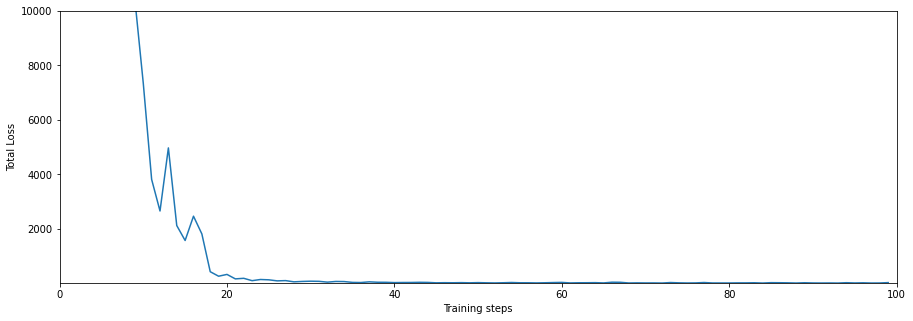

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.axis([0, 100, 20, 10000])
line1, = plt.plot(steps, total_loss)
plt.xlabel("Training steps")
plt.ylabel("Total Loss")
plt.show()

For reasons of computational tractability, the model is not actually tested since it was also only trained as a toy example. The code below can be used to test the model.

In [ ]:
# test = Test()
# test.test(sess)

### References
[1] Law, H., & Deng, J. (2018). Cornernet: Detecting objects as paired keypoints. In Proceedings of the European conference on computer vision (ECCV) (pp. 734-750).

[2] https://github.com/makalo/CornerNet